In [1]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
#import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_regression, make_circles
#from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
#from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

## 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

In [2]:
#для дальнейшего выполнения ДЗ реализуем дерево решений, как на уроке

In [3]:
# сгенерируем данные - добавила параметр n_samples, чтоб увеличить количество объектов

classification_data, classification_labels = make_classification(n_samples=500, n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=5)

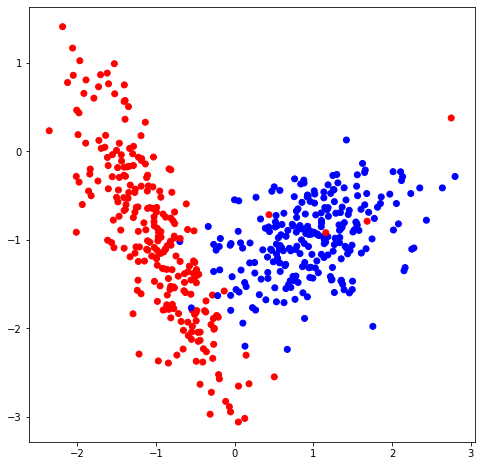

In [4]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [5]:
# Разобьем выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [6]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [7]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction    

In [8]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [9]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [10]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции (как на уроке)

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [13]:
#дерево с критерием останова по кличеству листев и глубине

def build_tree_up(data, labels, max_leaves):
    
    num_leaves = 0
    depth = 0
    max_leaves = max_leaves #количество листьев ограничивается при вызове функции
        
    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    #к нему добавляем стоп, когда количество листьев стало больше максимального
    
    if gain == 0 or num_leaves >= max_leaves - 1:
        num_leaves += 1
        
        return Leaf(data, labels)

    depth += 1
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_up(true_data, true_labels, max_leaves)
    false_branch = build_tree_up(false_data, false_labels, max_leaves)    

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [14]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [15]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [16]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [17]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [18]:
# Построим дерево по обучающей выборке с рекурсией
my_tree = build_tree(train_data, train_labels)
print_tree(my_tree)

Индекс 0 <= -0.051771417967220734
--> True:
  Индекс 0 <= -0.36637542342372253
  --> True:
    Индекс 0 <= -0.7126883788993976
    --> True:
      Прогноз: 0
    --> False:
      Индекс 1 <= -1.3373577592210018
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 0
  --> False:
    Индекс 1 <= -1.8741394984788107
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
--> False:
  Индекс 1 <= -2.238294346478628
  --> True:
    Прогноз: 0
  --> False:
    Индекс 0 <= 1.1573428257768366
    --> True:
      Прогноз: 1
    --> False:
      Индекс 0 <= 1.1878872129209608
      --> True:
        Прогноз: 1
      --> False:
        Прогноз: 1


In [31]:
# Построим дерево по обучающей выборке с критерием останова по количеству листьев и глубиной
#что-то пошло не так(( я не смогла подобрать параметры так, что остановка работала, и не смогла найти ошибку. HELP

my_tree = build_tree_up(train_data, train_labels, 2)
print_tree(my_tree)

Индекс 0 <= -0.051771417967220734
--> True:
  Прогноз: 0.02824858757062147
--> False:
  Индекс 1 <= -2.238294346478628
  --> True:
    Прогноз: 0.2
  --> False:
    Прогноз: 0.9940476190476191


In [20]:
def check_accuracy(my_tree):
    train_answers = predict(train_data, my_tree)

    train_accuracy = accuracy_metric(train_labels, train_answers)
    print(train_accuracy)

    answers = predict(test_data, my_tree)

    test_accuracy = accuracy_metric(test_labels, answers)
    print(test_accuracy)

In [21]:
check_accuracy(my_tree)

98.85714285714286
94.66666666666667


## 2. *Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [22]:
# сгенерируем данные
data, targets = make_regression(n_features=2, n_informative=2, random_state=5)

In [23]:
# Разобьем выборку на обучающую и тестовую

train_data_regr, test_data_regr, train_target_regr, test_target_regr = train_test_split(data, targets, test_size=0.3,
                                                                                        random_state=1)

In [24]:
# class Node: без изменений

In [25]:
#класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, targets): #labels --> targets
        self.data = data
        self.targets = targets
        self.prediction = self.predict()
        
    def predict(self):
        return self.targets.mean() # среднее значение по выборке

In [26]:
# среднеквадратичное отклонение (дисперсия)
def mse(targets):
    return np.mean((targets - targets.mean())**2)

In [27]:
# def gain, def split: без изменений

In [28]:
# Нахождение наилучшего разбиения

def find_best_split(data, targets):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 5

    root_mse = mse(targets) #целевой показатель - дисперсия

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_targets, false_targets = split(data, targets, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_targets, false_targets, root_mse)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [29]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, targets): #labels --> targets

    gain, t, index = find_best_split(data, targets)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, targets)

    true_data, false_data, true_target, false_target = split(data, targets, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_target)
    false_branch = build_tree(false_data, false_target)

    node = Node(index, t, true_branch, false_branch)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return node

In [30]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data_regr, train_target_regr)
print_tree(my_tree)

Индекс 0 <= -1.167278449710173
--> True:
  Прогноз: -121.39064849773837
--> False:
  Индекс 0 <= -0.8126247611063044
  --> True:
    Прогноз: -58.83807643952095
  --> False:
    Индекс 0 <= -0.5017555471945
    --> True:
      Прогноз: -50.68338930141631
    --> False:
      Индекс 0 <= -0.28143012121166766
      --> True:
        Прогноз: -19.53457742091028
      --> False:
        Индекс 0 <= 0.10134479014204936
        --> True:
          Индекс 0 <= -0.10593044205742323
          --> True:
            Прогноз: -19.179384142931184
          --> False:
            Прогноз: 11.007437547567205
        --> False:
          Индекс 0 <= 0.30364846530823975
          --> True:
            Прогноз: 17.82546436535075
          --> False:
            Индекс 0 <= 0.6178447508392777
            --> True:
              Индекс 0 <= 0.44295626086393586
              --> True:
                Прогноз: 32.35717501918585
              --> False:
                Прогноз: 44.73161236384692
            